
# Laboratorio de filtros digitales: Mitigación de Interferencias en el Electrocardiograma durante la Prueba de Esfuerzo 

### Gonzalo Goumaz


## Parte 1: Diseño de filtros

### Consigna

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:
<figure>
<center>
<img src="images/plantilla.svg">
<figcaption> Fig 1: Plantilla de diseño</figcaption>
</figure>
    
Se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados.  
    Mostrar la respuesta en frecuencia, para ambos filtros, de:
1. Módulo
2. Fase
3. Retardo
4. Respuesta al impulso.

### Desarrollo del filtro IIR

En el siguiente código se implementa el desarrollo de un filtro IIR que cumpla con la plantilla solicitada

In [1]:
# -------- Módulos a utilizar -------- # 

import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

import warnings
warnings.filterwarnings('ignore')

# ------------------------------------ #

In [2]:
# Para fijar el estilo de gráficos en el notebook

fig_sz_x = 13
fig_sz_y = 10
fig_dpi = 80
fig_font_size = 12

plt.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
plt.rcParams['figure.dpi'] = (fig_dpi)
plt.rcParams.update({'font.size':fig_font_size})

In [3]:
# ----- Requisitos de plantilla ------ #     

fs = 1e3 #Hz
f_nyq = fs/2

fs1 = 1.0 #Hz
fp1 = 3.0 #Hz
fp2 = 25.0 #Hz
fs2 = 35.0 #Hz
ripple = 0.5
att = 40

# ------------------------------------ #

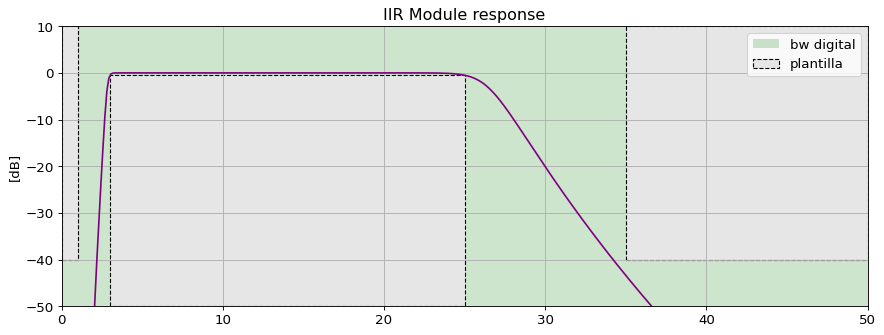

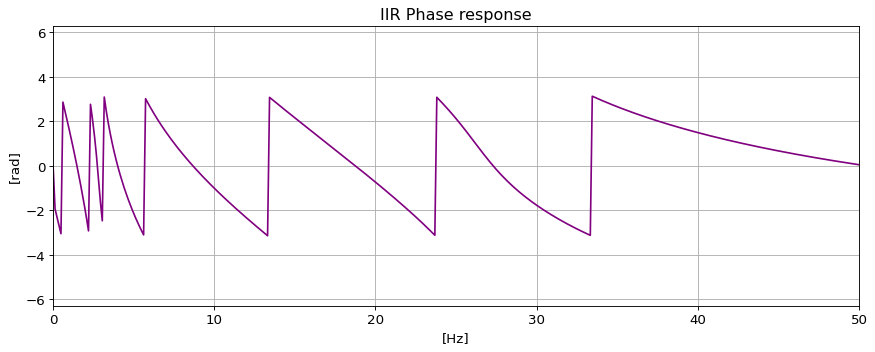

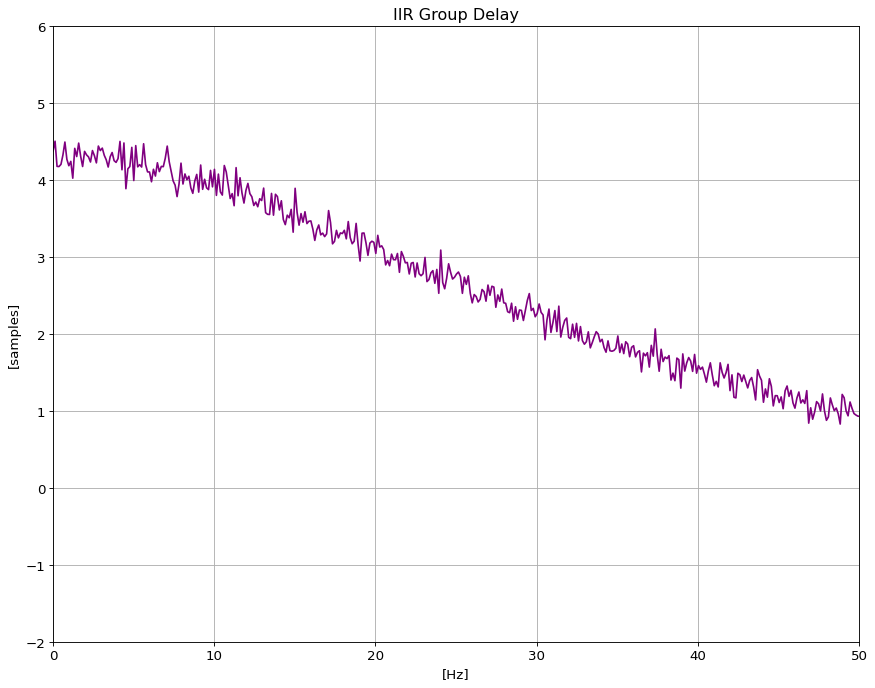

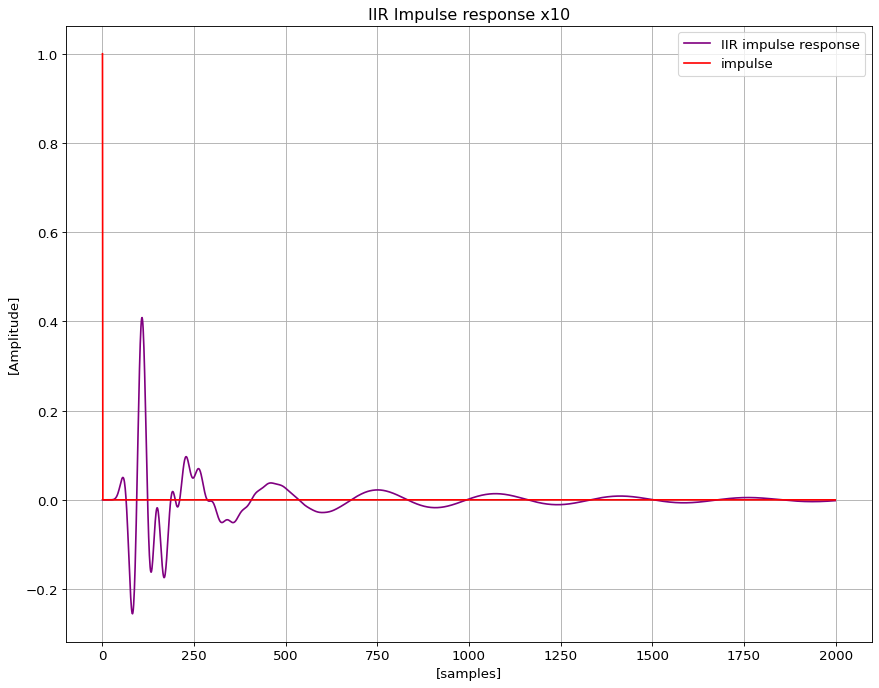

In [4]:
# ---- DiseÃ±o de filtro tipo IIR ----- #
worN=4096

f_pass = [fp1, fp2]
f_stop = [fs1, fs2]

bp_IIR_sos = sig.iirdesign(f_pass, f_stop, ripple, att, analog=False ,ftype='butter',output='sos', fs=fs)

num_IIR, den_IIR = sig.sos2tf(bp_IIR_sos)

ww_z, hh_z = sig.sosfreqz(bp_IIR_sos, worN=worN ,fs=fs)
#ww_z = ww_z * fs/(2*np.pi)

plt.close('all')
plt.figure(1)

## Plot de respuesta de mÃ³dulo
plt.subplot(2, 1, 1)
plt.grid(visible=True)
plt.title("IIR Module response")
plt.ylabel("[dB]")
plt.plot(ww_z, 20* np.log10(abs(hh_z)), color ='purple')
plt.axis([0, fs/20, -50, 10])

## Plot de plantilla
plot_plantilla(filter_type = 'bandpass', fpass = [fp1, fp2] , ripple = ripple , fstop = [fs1, fs2], attenuation = att, fs = fs)

## Plot de respuesta de fase
plt.subplot(2, 1, 2)
plt.grid(visible=True)
plt.title("IIR Phase response")
plt.ylabel("[rad]")
plt.xlabel('[Hz]')
plt.plot(ww_z, np.angle(hh_z) , color ='purple')
plt.axis([0, fs/20, -2*np.pi, 2*np.pi])

## Retardo de grupo
ww_gd, gd_IIR = sig.group_delay((num_IIR, den_IIR), w=worN ,fs=fs)

plt.figure(2)
plt.grid(visible=True)
plt.title("IIR Group Delay")
plt.ylabel("[samples]")
plt.xlabel('[Hz]')
plt.plot(ww_gd, gd_IIR, color ='purple')
plt.axis([0, fs/20, -2, 6])

## Respuesta al impulso

samples = 2000

impulse = sig.unit_impulse(samples)
IIR_h = sig.sosfilt(bp_IIR_sos, impulse)

plt.figure(3)
plt.grid(visible=True)
plt.title("IIR Impulse response x10")
plt.ylabel("[Amplitude]")
plt.xlabel('[samples]')
plt.plot(np.arange(0, samples), 10*IIR_h , color ='purple', label='IIR impulse response')
plt.plot(np.arange(0, samples), impulse , color ='red', label='impulse')

axes_hdl = plt.gca()
axes_hdl.legend()

# ------------------------------------ #


### Desarrollo del filtro FIR

A continuación se desarrolla un filtro de tipo FIR que cumpla con la plantilla solicitada. Para esto, se propone utilizar un método de ventanas.


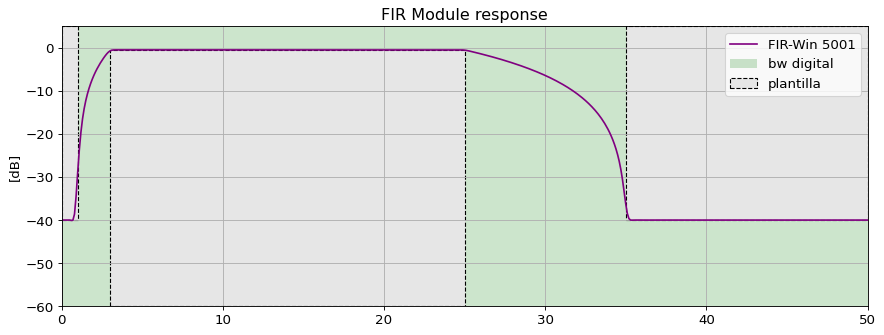

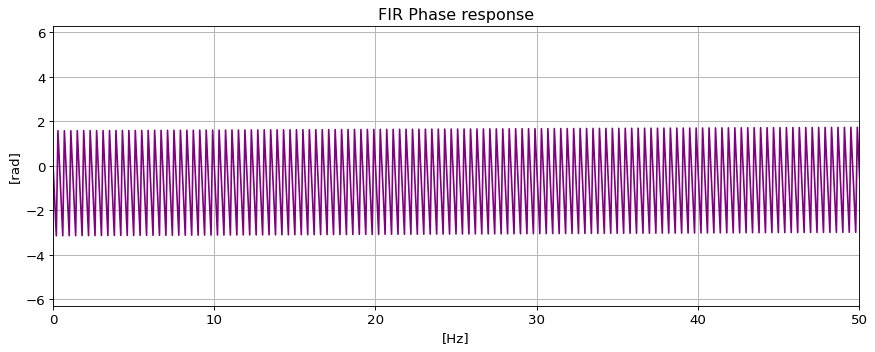

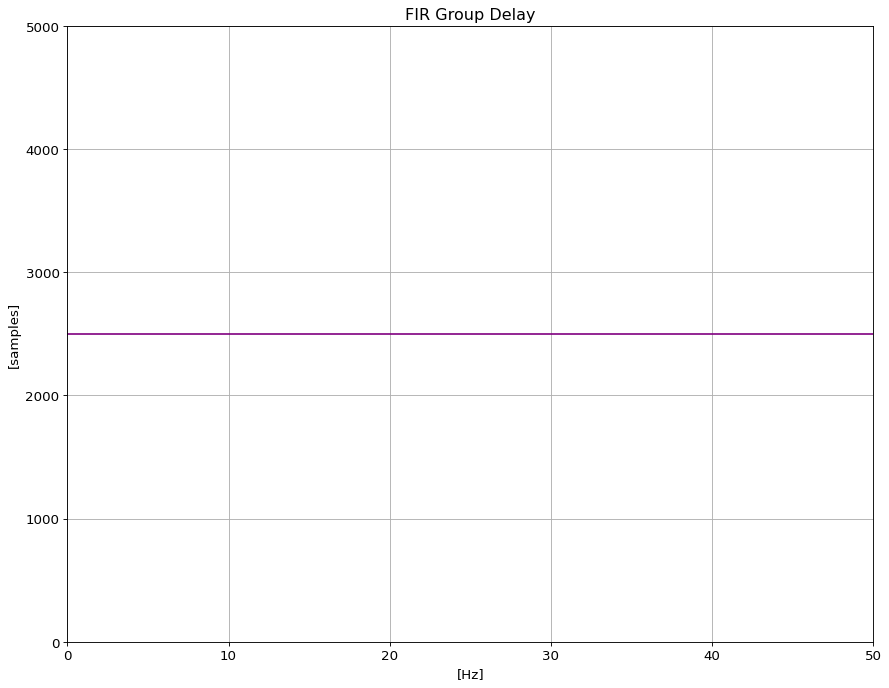

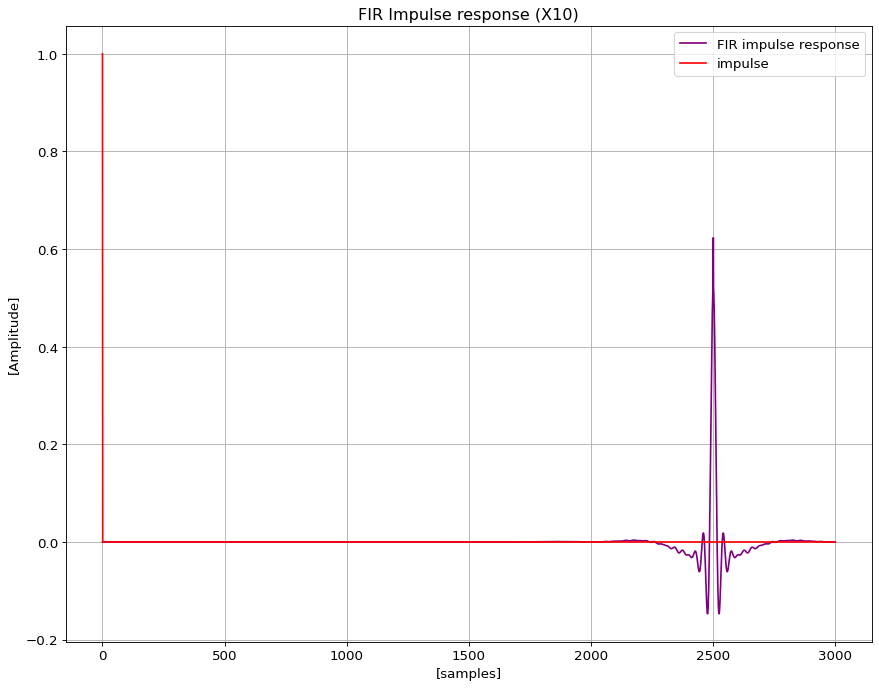

In [5]:
# ---- Diseño de filtro tipo FIR ----- #

n_taps = 5001
freq = np.array([0 , fs1, fp1, fp2, fs2 ,f_nyq])/f_nyq
gains = 10**(np.array([-att, -att, -ripple, -ripple, -att, -att])/20)

num_win = sig.firwin2(n_taps, freq, gains, window='hamming')
den = np.zeros(n_taps)
den[0] = 1.0

w, hh_win = sig.freqz(num_win, den, worN=n_taps)

# renormalizo el eje de frecuencia
w = w / np.pi * f_nyq

plt.figure(4)
## Plot de respuesta de modulo 
plt.subplot(2, 1, 1)
plt.grid(visible=True)
plt.title("FIR Module response")
plt.ylabel("[dB]")
plt.plot(w, 20 * np.log10(abs(hh_win)),color='purple' ,label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.axis([0, f_nyq/10, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

## Plot de plantilla
plot_plantilla(filter_type = 'bandpass', fpass = [fp1, fp2] , ripple = ripple , fstop = [fs1, fs2], attenuation = att, fs = fs)

## Plot de respuesta de fase
phase = np.angle(hh_win)

plt.subplot(2, 1, 2)
plt.grid(visible=True)
plt.title("FIR Phase response")
plt.ylabel("[rad]")
plt.xlabel('[Hz]')
plt.plot(w, phase , color ='purple', label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.axis([0, f_nyq/10, -2*np.pi, 2*np.pi])

## Retardo de grupo
ww_gd, gd_FIR = sig.group_delay((num_win, den), w=n_taps ,fs=fs)

plt.figure(5)
plt.grid(visible=True)
plt.title("FIR Group Delay")
plt.ylabel("[samples]")
plt.xlabel('[Hz]')
plt.plot(ww_gd, gd_FIR, color ='purple')
plt.axis([0, f_nyq/10, 0, n_taps-1])

## Respuesta al impulso

samples = 3000

impulse = sig.unit_impulse(samples)
FIR_h = sig.lfilter(num_win, den, impulse)

plt.figure(6)
plt.grid(visible=True)
plt.title("FIR Impulse response (X10)")
plt.ylabel("[Amplitude]")
plt.xlabel('[samples]')
plt.plot(np.arange(0, samples), 10*FIR_h , color ='purple', label='FIR impulse response')
plt.plot(np.arange(0, samples), impulse , color ='red', label='impulse')

axes_hdl = plt.gca()
axes_hdl.legend()

# ----------------------------- #


## Parte 2: Implementación y uso de los filtros

En esta parte se utilizarán los dos filtros diseñados para mitigar las interferencias. Para ello SciPy dispone de dos implementaciones de la ecuación de diferencias, la tradicional mediante **lfilter** y la variante por SOS's mediante **sosfilt**. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es obligatoria para filtros IIR de orden superior.

In [6]:
## - Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes - ##

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

### Uso del filtro FIR

Se procede a utilizar el filtro FIR diseñado para analizar como responde ante la señal del ECG.

In [7]:
# ---- Uso del filtro FIR ----  #

ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados.  
Primero revisaremos zonas de **alta contaminación** para evaluar qué tan eficiente es el filtrado.  
Recordar que **cada filtro impone una demora a la señal filtrada**, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede adelantarse.

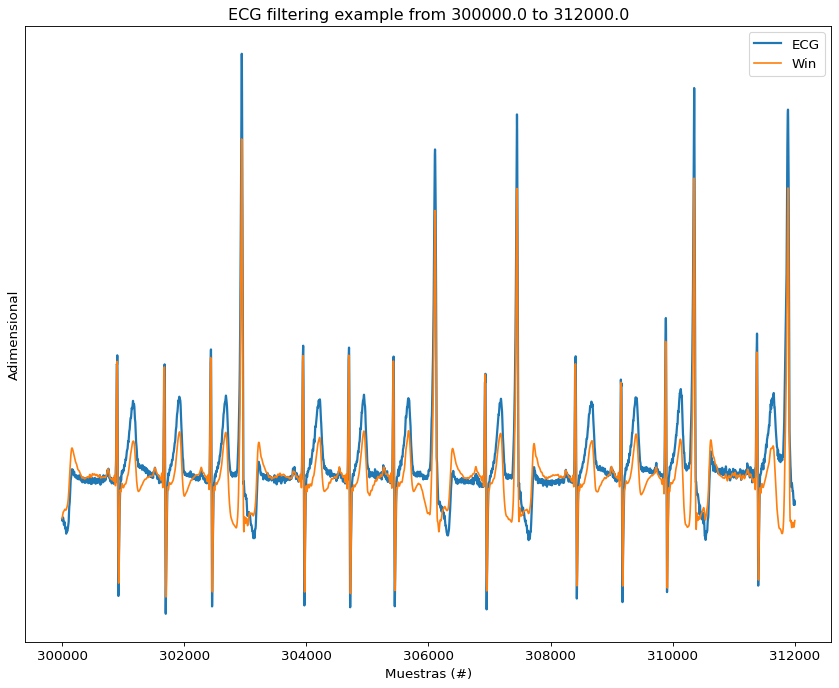

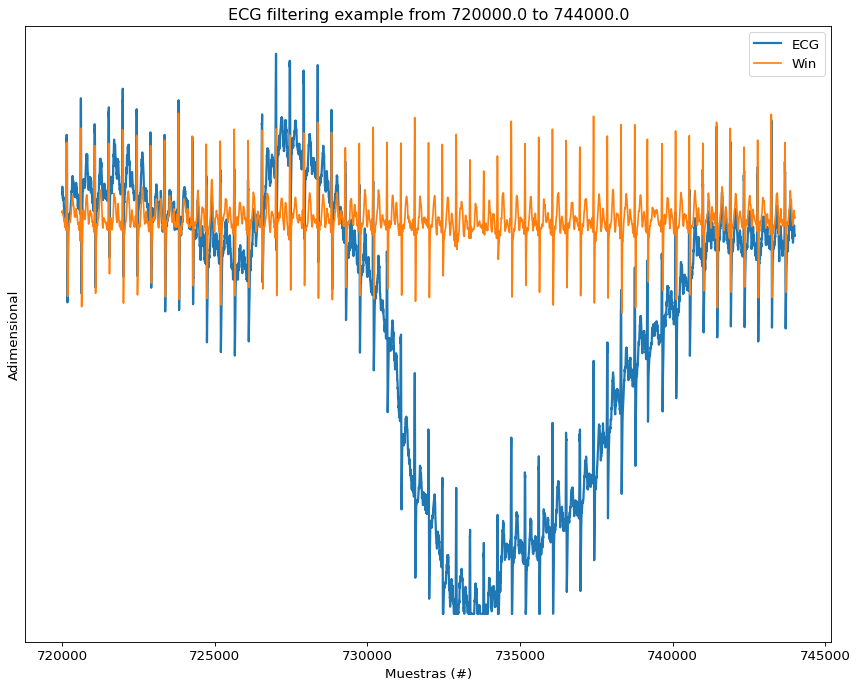

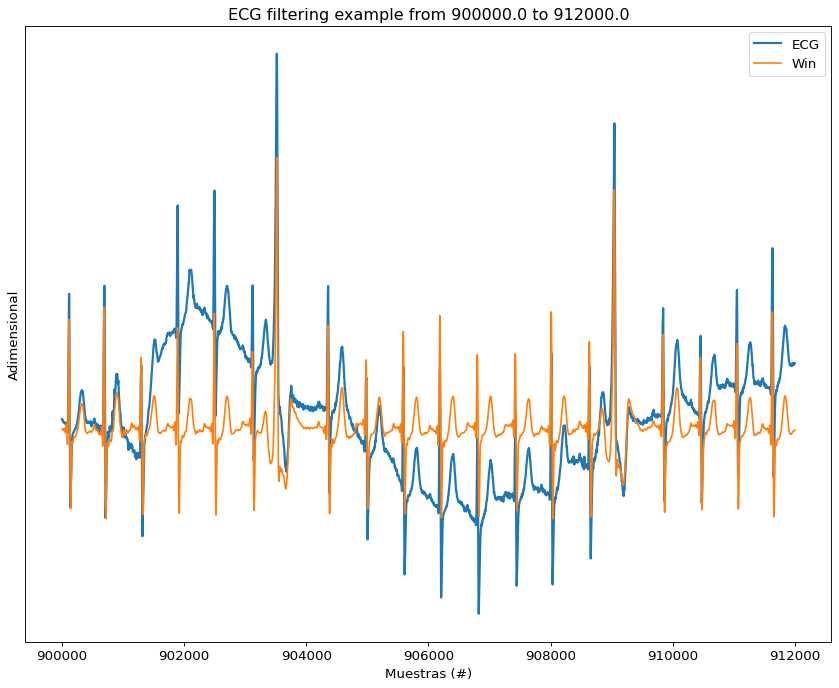

In [8]:
## Calculo la demora introducida

demora = int(np.round(gd_FIR[500])) # FIR tiene gd cte


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
# ----------------------------- #

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es inocua cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente.  
Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos **con baja contaminación**, es decir qué tan **inocuo** es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

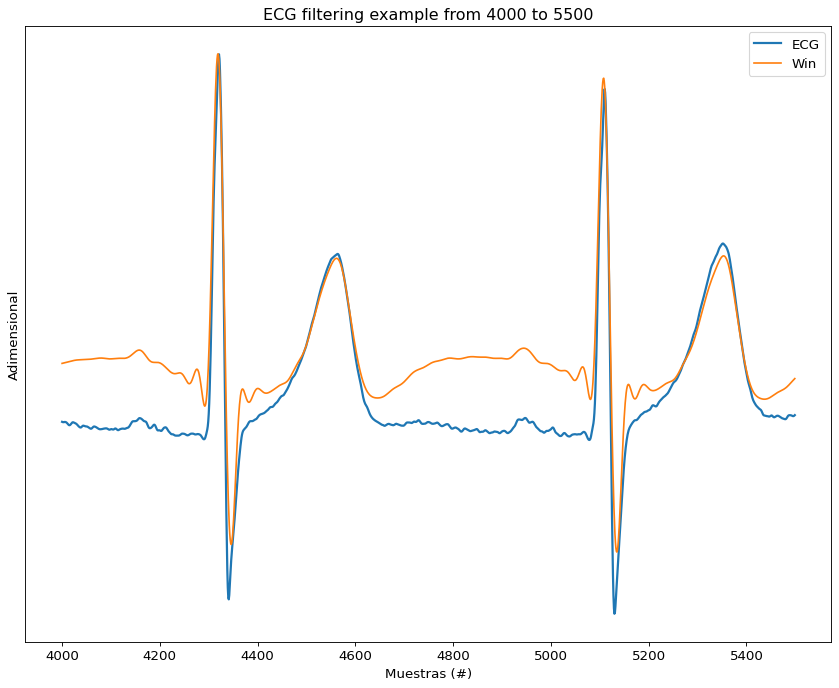

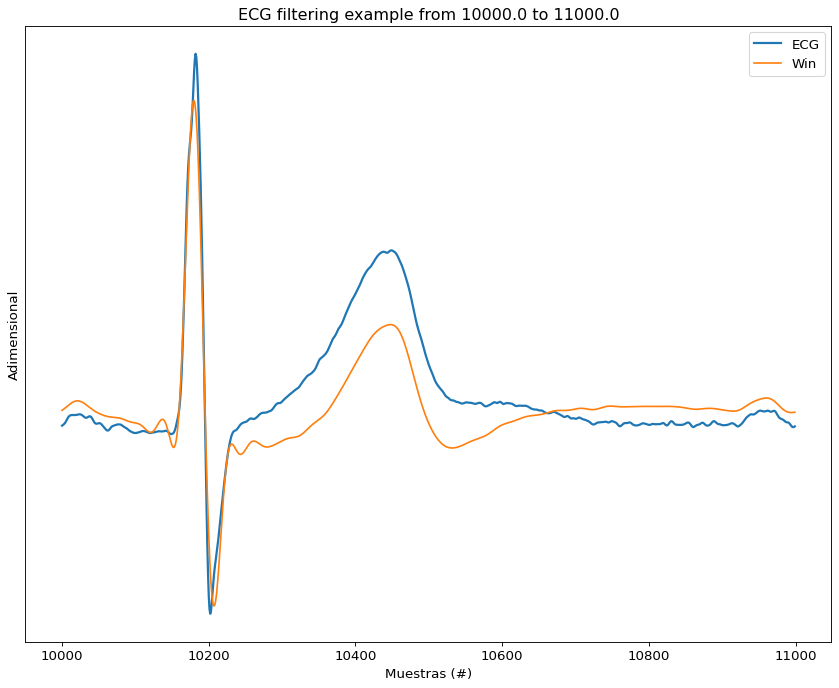

In [9]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

### Uso del filtro IIR

Ahora se procede a utilizar el filtro IIR.

Análisis en zona de **ALTA contaminación**

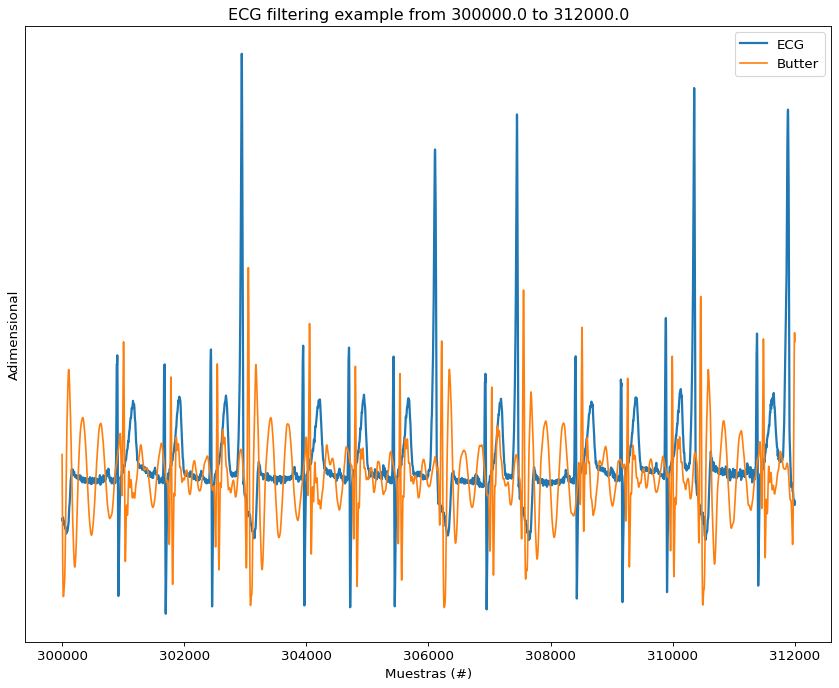

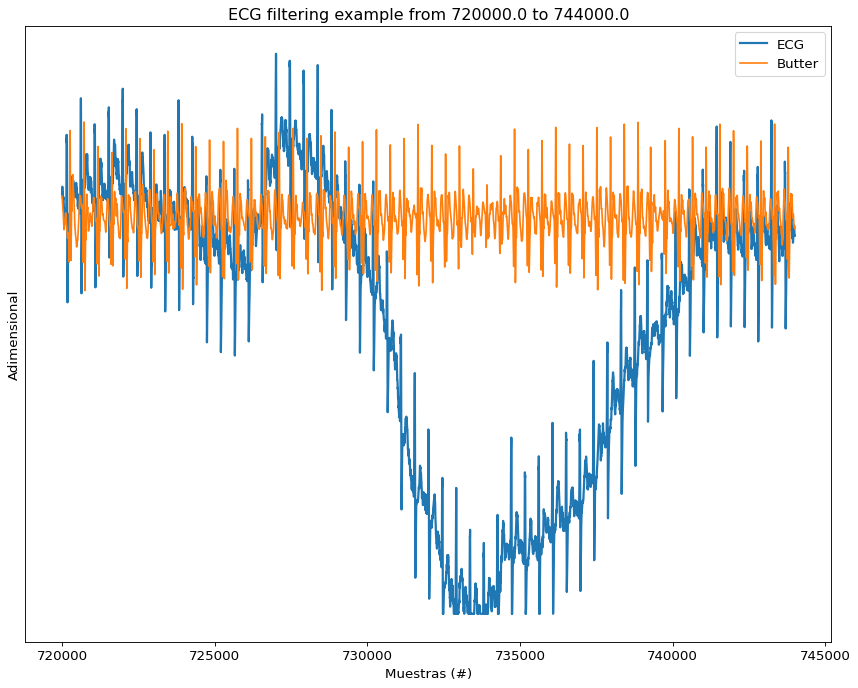

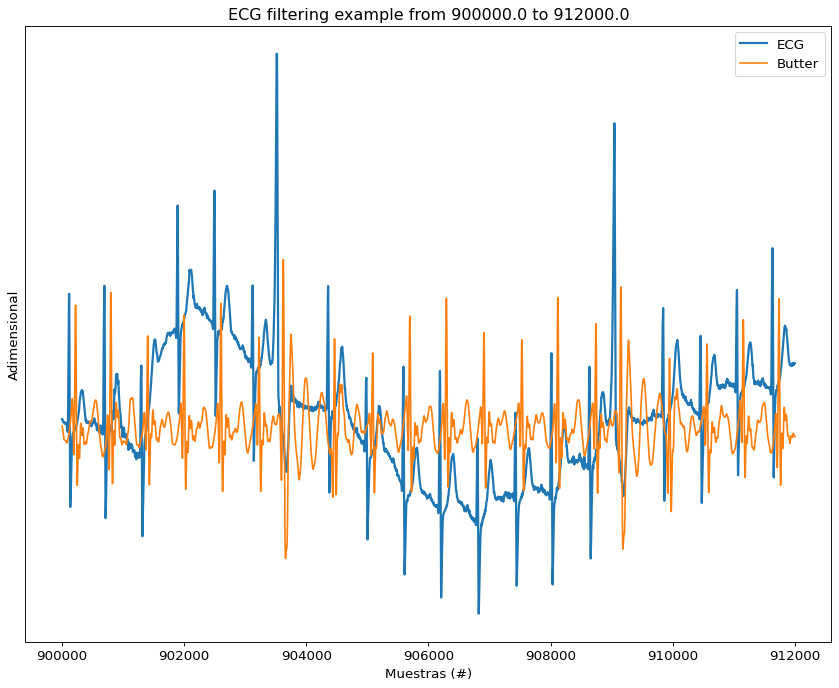

In [12]:

ECG_f_butt = sig.sosfilt(bp_IIR_sos, ecg_one_lead)

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Análisis de la respuesta IIR en zona de **BAJA contaminación**

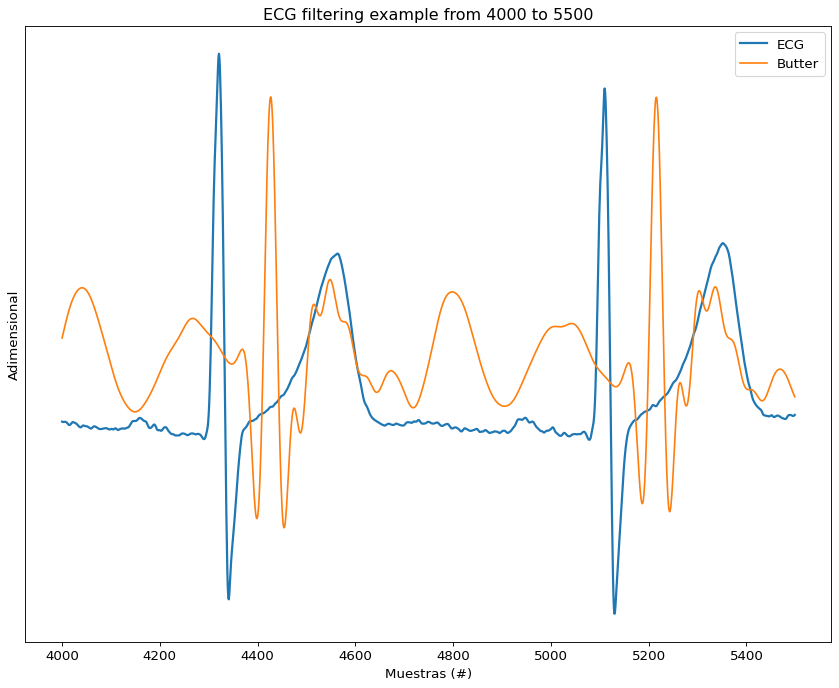

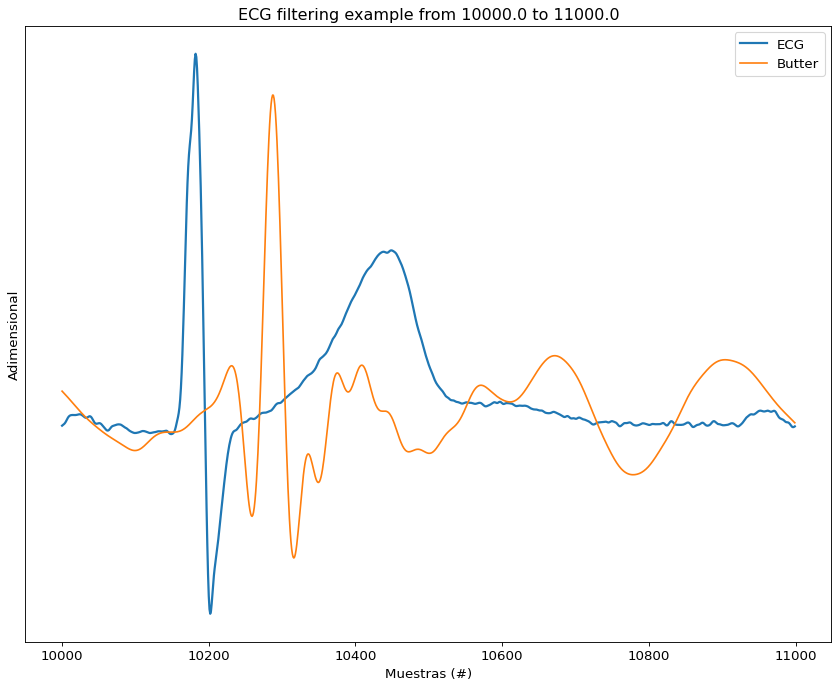

In [13]:
# Segmentos de interés con BAJA contaminación
    
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


# ----------------------------- #


### Implementación mediante filtrado bidireccional

Finalmente implementaremos **los mismos filtros** con una técnica diferente llamada *filtrado bidireccional* *[scipy.signal.filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html)*.

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), **no** producen distorsión de fase debido a que su fase **es lineal**. 

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un **filtro de fase cero**. Recordemos que la transformada de Fourier de la inversión en tiempo es 

\begin{equation}
x[-k] \stackrel{\mathrm{DFT}}{\longleftrightarrow} X^*(e^{j \, \Omega })
\end{equation}

Por lo tanto, vemos que la inversión en tiempo conlleva la negación de la respuesta de fase de una señal. Entonces utilizaremos una doble inversión temporal para cancelar los efectos de fase, y al mismo tiempo el resultado neto sobre la señal espejada dos veces será nulo

\begin{equation}
Y(e^{j \, \Omega }) = X(e^{j \, \Omega }) \cdot T^*(e^{j \, \Omega }) \cdot T(e^{j \, \Omega }) 
\end{equation}

\begin{equation}
Y = X \cdot |T|^2
\end{equation}

*(Se simplificó la notación para clarificar el resultado)* Se observa como resultado de aplicar el método bidireccional un filtro equivalente al cuadrado del módulo y con aporte nulo de fase para todas las frecuencias. Esto equivale a haber atravesado dos veces por el mismo filtro, por lo tanto la atenuación será el doble que la del filtro original (y el *ripple* en banda también!) razón por lo cual debe modificarse la plantilla de diseño **relajando a la mitad** la atenuación, es decir exigiendo menos atenuación, pero **duplicando** la exigencia de ripple, es decir dividiendo por dos el ripple.

Nuevamente, primero se analiza la respuesta de los filtros en una zona de ALTA contaminación

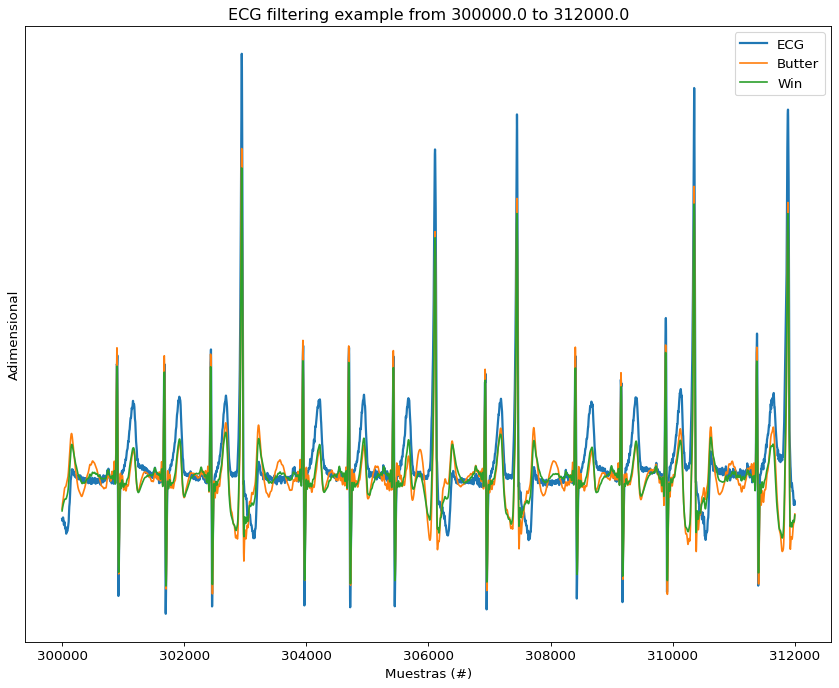

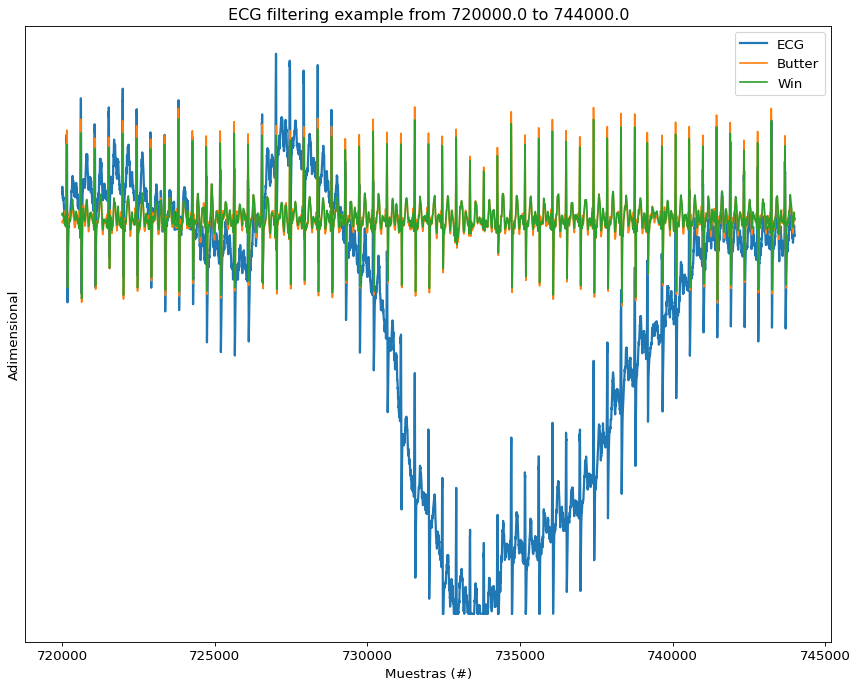

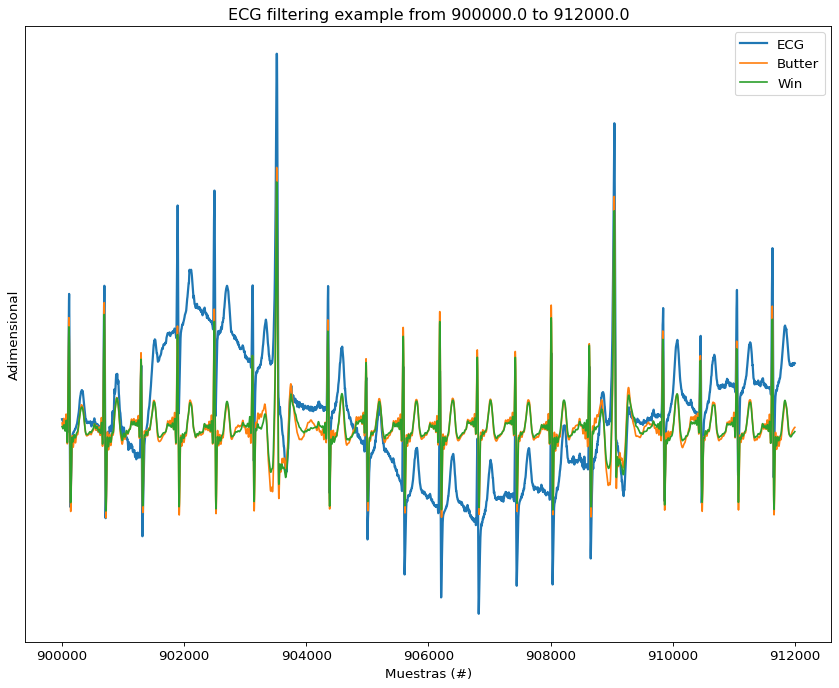

In [10]:
## --- Segmentos de interés con alta contaminación --- ##

# Procedemos al filtrado
ECG_f_butt = sig.sosfiltfilt(bp_IIR_sos, ecg_one_lead)
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


Se analiza a continuación como responden ambos filtros en su banda de paso. Para esto, se analiza una región de **BAJA contaminación**.

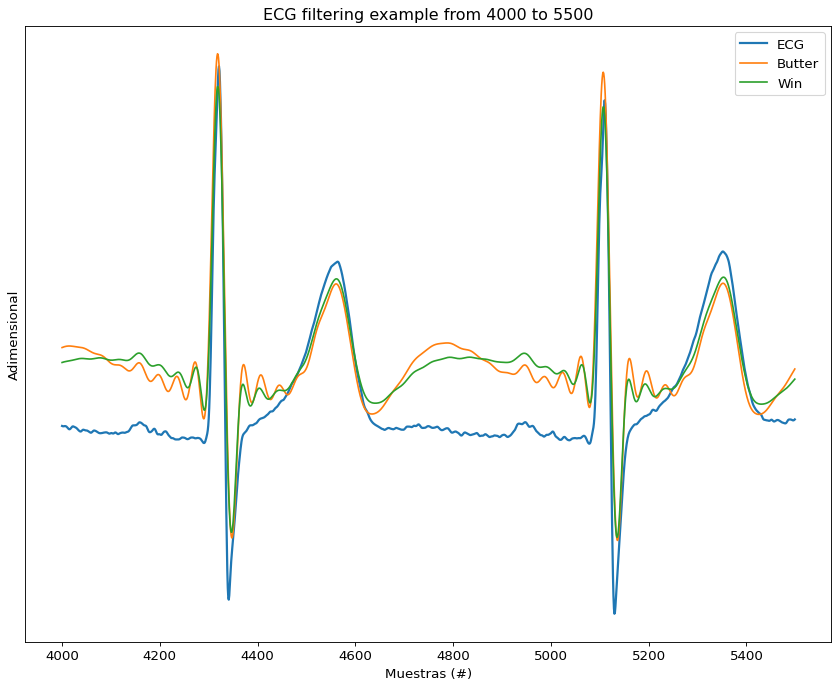

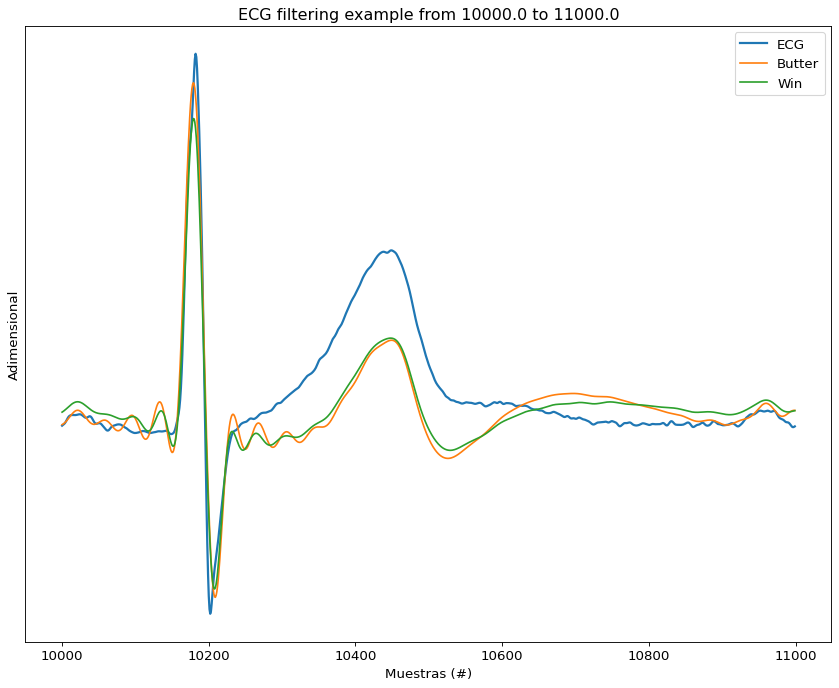

In [11]:
## --- Segmentos de interés con baja contaminación --- #

regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

# ----------------------------- #

Como se observa, la señal de ECG ha sido alterada en su morfología, a pesar de que **la fase no pudo haber sido la responsable** luego de haber usado el filtrado bidireccional. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como **oscilaciones que no estaban presentes en el ECG original**. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.

Quedan pendiente las siguientes cuestiones, en caso que los filtros no se hayan comportado de acuerdo a lo esperado:

  1. ¿Qué pudo haber causado que los filtros no hayan sido **eficientes** para eliminar las interferencias? 
  2. ¿Qué pudo haber causado que los filtros no hayan sido **inocuos** respecto a las señales NO contaminadas? 
  
Y en caso que los filtros hayan funcionado como esperaba, reflexione sobre cómo los utilizaría en una arquitectura digital como las usadas en las **Informáticas** o las **Técnicas Digitales**.
  

Vamos con las respuestas a estas preguntas.
1. Existen varios motivos a los que se le puede atribuir la ineficiencia del filtro para eliminar las interferencias. Una posible explicación sería que la plantilla de diseño debe reajustarse ya que, es posible, que no sea lo suficientemente adecuada. Además, se pueden tener interferencias debido al ruido ubicado en la misma banda de frecuencia de la señal bajo análisis.
2. En base a las simulaciones con los métodos de filtrado bidireccional se puede afirmar que la distorsión no puede ser atribuida a la fase. La razón por la que los filtros no responden como deberían frente a señales no contaminadas es su respuesta al impulso, disparada por el complejo QRS de la señal del ECG.